In [1]:
#Analysis is done using the datasets obtained through this kaggle project: https://www.kaggle.com/zynicide/wine-reviews
#Wanting to several different models. One to predict the rating of a wine using the description alone. 
#Another to predict whether it's a white, red, or other.
#Maybe one to predict it's origin, using KNN or similar.
#There is a correlation between length of description and it's points, and a correlation between price and points also. 
import nltk
from nltk.corpus import stopwords
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
wine_1 = pd.read_csv('winemag-data_first150k.csv', index_col=0)

In [3]:
wine_1.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [4]:
wine_2 = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)

In [5]:
wine_2.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [6]:
#These all seem like good wines, as they have a min rating of 80/100 and std of only 3.
wine_2.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [7]:
##Create new variable in wine_2 for length of review
wine_2['length'] = wine_2['description'].apply(len)

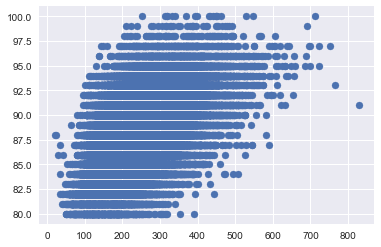

In [8]:
#slight skew to the right indicating longer review length for higher rating, but not a big skew.
plt.scatter(data=wine_2, x='length', y='points')

In [9]:
#we'll clean up the description column to remove stopwords and punctuation
def clean_text(desc):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in desc if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [10]:
#apply the function to the description column to see if it works
wine_2['description'].head(5).apply(clean_text)

0    [Aromas, include, tropical, fruit, broom, brim...
1    [ripe, fruity, wine, smooth, still, structured...
2    [Tart, snappy, flavors, lime, flesh, rind, dom...
3    [Pineapple, rind, lemon, pith, orange, blossom...
4    [Much, like, regular, bottling, 2012, comes, a...
Name: description, dtype: object

In [11]:
#will split 'points' column into a 5 star rating system to make for easier classification
def rating(points):
    if (points<=84):
        return 1
    elif (points>84) & (points<=88):
        return 2
    elif (points>88) & (points<=92):
        return 3
    elif (points>92) & (points<=96):
        return 4
    else:
        return 5        

In [12]:
wine_2['rating'] = wine_2['points'].apply(rating)

In [13]:
#We need to now vectorize the descriptions to make a bag of words dataset
#Takes 30 mins to run..
from sklearn.feature_extraction.text import CountVectorizer
bow_transform = CountVectorizer(analyzer=clean_text).fit(wine_2['description'])


NameError: name 'bow_transformer' is not defined

In [14]:
print(len(bow_transform.vocabulary_))

52621


In [15]:
#Takes a while to run
description_bow = bow_transform.transform(wine_2['description'])

In [16]:
print('Shape of Sparse Matrix: ', description_bow.shape)
print('Amount of Non-Zero occurences: ', description_bow.nnz)

Shape of Sparse Matrix:  (129971, 52621)
Amount of Non-Zero occurences:  3172698


In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(description_bow)
description_tfidf = tfidf_transformer.transform(description_bow)

In [18]:
#Fit a multinomial naive bayes model to predict a rating of a review based on the content of the description
from sklearn.naive_bayes import MultinomialNB
rating_pred_model = MultinomialNB().fit(description_tfidf, wine_2['rating'])

In [19]:
#test the predictiveness using a classification report.
from sklearn.metrics import classification_report
all_predictions = rating_pred_model.predict(description_tfidf)
print (classification_report(wine_2['rating'], all_predictions))

             precision    recall  f1-score   support

          1       0.98      0.09      0.16     12430
          2       0.66      0.86      0.75     56270
          3       0.64      0.74      0.69     48608
          4       0.91      0.02      0.04     12305
          5       0.00      0.00      0.00       358

avg / total       0.71      0.66      0.60    129971



C:\Users\miah.stewart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
